# Pràctica 2
### Autors:
<ul>
    <li>Gerard Medina</li>
    <li>Xisco Cerdó</li>
</ul>

## Imports

In [18]:
import os
import shutil
import torch
import torch.nn 
import torch.optim
from tqdm import tqdm
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


## Classificar el Dataset

In [3]:
# Set the path to the dataset directory
old_dataset = "datasets/old_pets/images/"

# Set the paths for the output directories
carpeta_moixos = "datasets/CNN/moix/"
carpeta_cans = "datasets/CNN/ca/"

# Create the output directories if they don't exist
os.makedirs(carpeta_moixos, exist_ok=True)
os.makedirs(carpeta_cans, exist_ok=True)

# Get the list of all files in the dataset directory
all_files = os.listdir(old_dataset)

# Loop through each file and copy it to the appropriate directory
for filename in all_files:
    full_path = os.path.join(old_dataset, filename)
    if filename[0].islower():
        shutil.copy(full_path, os.path.join(carpeta_cans, filename))
    elif filename[0].isupper():
        shutil.copy(full_path, os.path.join(carpeta_moixos, filename))

## Carregar el Dataset

In [2]:
new_dataset = "datasets/CNN/"

# Define the transformations to be applied to the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root=new_dataset, transform=transform)

# Define the data loader
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Mostrar exemples nou Dataset

Number of images in dataset:  7390


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

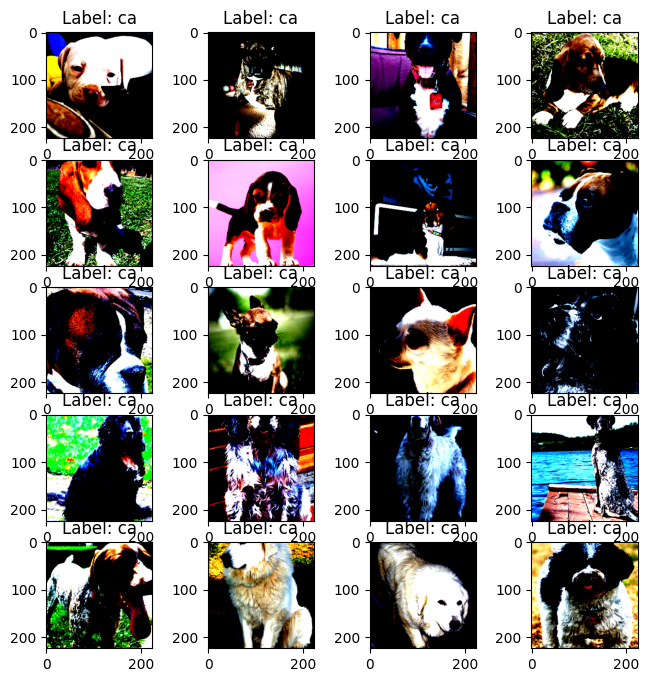

In [3]:
# Print the length of the dataset
print("Number of images in dataset: ", len(dataset))

# Show some sample images
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img_idx = i*100
    img, label = dataset[img_idx]
    fig.add_subplot(rows, columns, i)
    plt.title("Label: "+dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))
plt.show()

# Build the Model


In [4]:

class PetCNN(torch.nn.Module):
    def __init__(self, num_classes=37):
        super(PetCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(28*28*128, 512)
        self.relu4 = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(-1, 28*28*128)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
train_size = round(int(len(dataset)*.75))
test_size = len(dataset)-train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size,test_size])

In [8]:
# Set the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = PetCNN().to(device)

cuda


In [12]:
# training hyperparameters
batch_size = 32
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 8

In [13]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [14]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

In [15]:
# Train the model
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_valid_acc = 0.0  # variable to keep track of the best validation accuracy so far

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    valid_loss, valid_acc = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")
          
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'train_accs': train_accs,
            'valid_losses': valid_losses,
            'valid_accs': valid_accs
        }
        torch.save(checkpoint, 'pet_checkpoint.pt')

  0%|          | 0/174 [00:00<?, ?it/s]

100%|██████████| 58/58 [00:49<00:00,  1.18it/s]


Epoch 1/8, Train Loss: 0.7348, Train Acc: 0.6523, Valid Loss: 0.5885, Valid Acc: 0.6694


100%|██████████| 58/58 [00:15<00:00,  3.64it/s]


Epoch 2/8, Train Loss: 0.5691, Train Acc: 0.7028, Valid Loss: 0.5583, Valid Acc: 0.7083


100%|██████████| 58/58 [00:32<00:00,  1.80it/s]


Epoch 3/8, Train Loss: 0.4845, Train Acc: 0.7604, Valid Loss: 0.5159, Valid Acc: 0.7435


100%|██████████| 58/58 [00:15<00:00,  3.70it/s]


Epoch 4/8, Train Loss: 0.4091, Train Acc: 0.8051, Valid Loss: 0.6084, Valid Acc: 0.7208


100%|██████████| 58/58 [00:15<00:00,  3.77it/s]


Epoch 5/8, Train Loss: 0.3217, Train Acc: 0.8576, Valid Loss: 0.6620, Valid Acc: 0.7440


100%|██████████| 58/58 [00:16<00:00,  3.52it/s]


Epoch 6/8, Train Loss: 0.2159, Train Acc: 0.9105, Valid Loss: 0.6972, Valid Acc: 0.7451


100%|██████████| 58/58 [00:16<00:00,  3.42it/s]


Epoch 7/8, Train Loss: 0.1177, Train Acc: 0.9527, Valid Loss: 0.9864, Valid Acc: 0.7646


100%|██████████| 58/58 [00:18<00:00,  3.10it/s]


Epoch 8/8, Train Loss: 0.0590, Train Acc: 0.9794, Valid Loss: 0.9696, Valid Acc: 0.7711


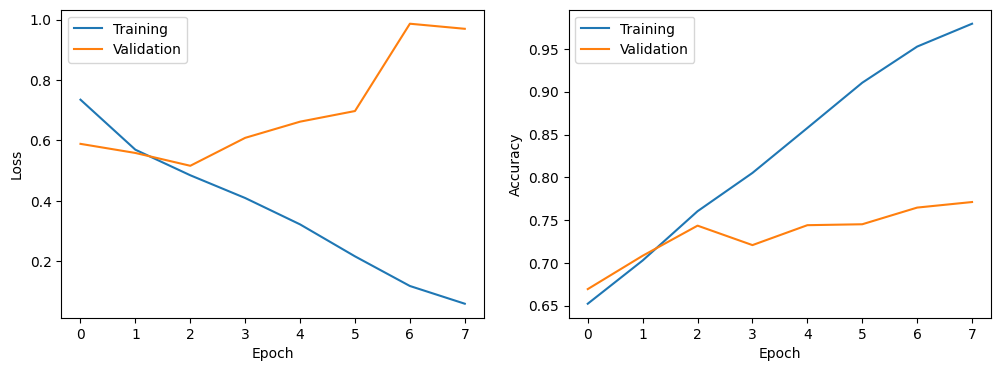

In [33]:
# Move tensors to CPU before plotting
#train_losses = train_losses.cpu().numpy()
#valid_losses = valid_losses.cpu().numpy()
#train_accs_cpu = train_accs.cpu().numpy()
#valid_accs_cpu = valid_accs.cpu().numpy()

train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
valid_accs_cpu = [acc.cpu().numpy() for acc in valid_accs]

# Plot the training and validation losses and accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training')
plt.plot(valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs_cpu, label='Training')
plt.plot(valid_accs_cpu, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
image_path = "images/moix.jpg"
image = Image.open(image_path)
input_image = transform(image).unsqueeze(0).to(device)

# Make a prediction
with torch.no_grad():
    output = model(input_image)

# Get the predicted class index
_, predicted_class = torch.max(output, 1)

# Print the predicted class
print(f'És un: {dataset.classes[predicted_class.item()]}.')

És un: moix.
